In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import qutip

import sys
sys.path.append("../../../Archive/Research/INQNET/superdense")
import squanch


from keras import backend as K
from keras.models import Sequential
from keras.layers import Layer
from keras.optimizers import SGD, Adam

K.set_floatx('float64')

Using TensorFlow backend.


In [2]:
BS_MATRIX = 1 / np.sqrt(2) * np.array([[1 + 0j, 0 + 1j], [0 + 1j, 1 + 0j]], dtype=np.complex128)
CPHASE = np.array([[1, 0, 0, 0],
                   [0, 1, 0, 0],
                   [0, 0,-1, 0],
                   [0, 0, 0, 1]], dtype=np.complex128)
IDENTITY = np.eye(2, dtype=np.complex128)

In [3]:
def k_complex_from_real(x):
    return tf.stack([x, tf.zeros_like(x)], axis=1)

def k_real(x):
    return x[:, 0, :]

def k_imag(x):
    return x[:, 1, :]

def np_to_k_complex(x):
    return np.stack([np.real(x), np.imag(x)], axis=1)

def k_to_tf_complex(x):
    return tf.complex(k_real(x), k_imag(x))

def tf_to_k_complex(x):
    return tf.stack([tf.real(x), tf.imag(x)], axis=1)

def np_to_complex(x):
    return np.array(k_real(x) + 1j * k_imag(x), dtype=np.complex128)

def reshape_state_vector(state):
    dim = int(np.sqrt(len(state)))
    return np.reshape(state, (dim, dim))

In [4]:
def get_random_state_vector(num_wires):
    '''Returns a random 2**n-sized complex-valued state vector'''
    N = 2 ** num_wires
    mags = np.random.rand(N)
    mags /= np.linalg.norm(mags)
    phases = np.exp(1j * 2 * np.pi * np.random.rand(N))
    return mags * phases

def tensor_product(state1, state2):
    '''
    Returns the Kronecker product of two states

    :param np.array state1: the first state
    :param np.array state2: the second state
    :return: the tensor product
    '''
    if len(state1) == 0:
        return state2
    elif len(state2) == 0:
        return state1
    else:
        return np.kron(state1, state2)


def tensors(operator_list):
    '''
    Returns the iterated Kronecker product of a list of states

    :param [np.array] operator_list: list of states to tensor-product
    :return: the tensor product
    '''
    result = []
    for operator in operator_list:
        result = tensor_product(result, operator)
    return result

In [5]:
def phase_shifts_to_tensor_product_space(phi_0, phi_1):
    phi_0_complex = tf.complex(tf.cos(phi_0), tf.sin(phi_0))
    phi_1_complex = tf.complex(tf.cos(phi_1), tf.sin(phi_1))

    single_qubit_ops = tf.unstack(tf.map_fn(lambda U: tf.diag(U), tf.transpose([phi_0_complex, phi_1_complex])))
    
    return tf.linalg.LinearOperatorKronecker([tf.linalg.LinearOperatorFullMatrix(U) for U in single_qubit_ops])

In [6]:
class SingleQubitOperationLayer(Layer):

    def __init__(self, num_qubits, **kwargs):
        self.num_qubits = num_qubits
        self.output_dim = 2 ** num_qubits
        super(SingleQubitOperationLayer, self).__init__(**kwargs)

    def build(self, input_shape):        
        input_dim = input_shape[-1]
        assert input_dim == self.output_dim
        
        initializer = keras.initializers.RandomUniform(minval=0, maxval=2*np.pi)

        # Create a trainable weight variable for this layer.
        self.alphas = self.add_weight(name='alphas',
                                      dtype=tf.float64,
                                      shape=(self.num_qubits,),
                                      initializer=initializer)
        self.betas  = self.add_weight(name='betas',
                                      dtype=tf.float64,
                                      shape=(self.num_qubits,),
                                      initializer=initializer)
        self.thetas = self.add_weight(name='thetas',
                                      dtype=tf.float64,
                                      shape=(self.num_qubits,),
                                      initializer=initializer)
        self.phis   = self.add_weight(name='phis',
                                      dtype=tf.float64,
                                      shape=(self.num_qubits,),
                                      initializer=initializer)
        
        self.input_shifts = phase_shifts_to_tensor_product_space(self.alphas, self.betas).to_dense()
        self.theta_shifts = phase_shifts_to_tensor_product_space(self.thetas, tf.zeros_like(self.thetas)).to_dense()
        self.phi_shifts = phase_shifts_to_tensor_product_space(self.phis, tf.zeros_like(self.phis)).to_dense()
        
        self.bs_matrix = tf.convert_to_tensor(tensors([BS_MATRIX] * self.num_qubits), dtype=tf.complex128)
        
        super(SingleQubitOperationLayer, self).build(input_shape) 

    def call(self, x):
        
        out = k_to_tf_complex(x)
        
        out = K.dot(out, self.input_shifts)
        out = K.dot(out, self.bs_matrix)
        out = K.dot(out, self.theta_shifts)
        out = K.dot(out, self.bs_matrix)
        out = K.dot(out, self.phi_shifts)
        
        return tf_to_k_complex(out)

    def compute_output_shape(self, input_shape):
        return input_shape


In [7]:
class CPhaseLayer(Layer):

    def __init__(self, num_qubits, parity=0, **kwargs):
        self.num_qubits = num_qubits
        self.parity = parity
        self.output_dim = 2 ** num_qubits
        super(CPhaseLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        input_dim = input_shape[-1]
        assert input_dim == self.output_dim
        
        ops = []
        if self.parity == 0:
            num_cphase = self.num_qubits // 2
            ops = [CPHASE] * num_cphase
            if 2 * num_cphase < self.num_qubits:
                ops.append(IDENTITY)
        else:
            ops = [IDENTITY]
            num_cphase = (self.num_qubits - 1) // 2
            ops.extend([CPHASE] * num_cphase)
            if 2 * num_cphase + 1 < self.num_qubits:
                ops.append(IDENTITY)
        
        self.transfer_matrix = tf.convert_to_tensor(tensors(ops), dtype=tf.complex128)
        
        super(CPhaseLayer, self).build(input_shape) 

    def call(self, x):
        
        out = k_to_tf_complex(x)
        
        out = K.dot(out, self.transfer_matrix)
        
        return tf_to_k_complex(out)

    def compute_output_shape(self, input_shape):
        return input_shape

In [8]:
def build_model(N, depth):
    layers = [SingleQubitOperationLayer(N)]
    for i in range(depth):
        layers.append(CPhaseLayer(N, parity=i%2))
        layers.append(SingleQubitOperationLayer(N))

    return Sequential(layers)

In [9]:
def QFT(qubits):
    '''Applies quantum Fourier transform to inputs'''
    N = len(qubits)
    for n in range(N, 0, -1):
        target = qubits[N - n]
        squanch.H(target)
        for m in range(1, n):
            squanch.CPHASE(qubits[N - n + m], target,2*np.pi/2**(m+1))

In [17]:
N = 5
states = np.array([get_random_state_vector(N) for _ in range(10000)])
states[0] = np.array([1]  + [0] * (2**N - 1), dtype=np.complex128)

qstream = squanch.QStream.from_array(np.copy(states), use_density_matrix=False)
for qsys in qstream:
    QFT(list(qsys.qubits))

out_states = np.copy(qstream.state)

in_data = np_to_k_complex(states)
out_data = np_to_k_complex(out_states)

In [18]:
learning_rate = 0.001 # 2**N * 0.001
opt = Adam(lr=learning_rate)
    
model = build_model(N, 4*N)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])
history = model.fit(in_data, out_data, epochs=10)

Epoch 1/10
10000/10000 [==============================] - 26s 3ms/step - loss: 0.0237 - mean_squared_error: 0.0237
Epoch 2/10
10000/10000 [==============================] - 10s 968us/step - loss: 0.0137 - mean_squared_error: 0.0137
Epoch 3/10
10000/10000 [==============================] - 10s 984us/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 4/10
10000/10000 [==============================] - 10s 975us/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 5/10
10000/10000 [==============================] - 10s 985us/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 6/10
10000/10000 [==============================] - 10s 967us/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 7/10
10000/10000 [==============================] - 10s 987us/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 8/10
10000/10000 [==============================] - 10s 982us/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 9/10
10000/10000 [==============================] - 10s 975u

In [19]:
model.predict(in_data[0:1])

array([[[ 0.1549756 ,  0.1395045 ,  0.14451396,  0.15081312,
          0.13407134,  0.15063724,  0.1422041 ,  0.14392533,
          0.2000438 ,  0.2015198 ,  0.19318981,  0.19745244,
          0.16427104,  0.1578724 ,  0.16746192,  0.16327633,
          0.17804712,  0.17255895,  0.17605451,  0.18917548,
          0.15360957,  0.1609658 ,  0.17092726,  0.16681499,
          0.16112788,  0.17072288,  0.16581433,  0.15749265,
          0.14225152,  0.12737895,  0.12292955,  0.13509052],
        [-0.10501152, -0.10401673, -0.08956988, -0.11833385,
         -0.10293978, -0.11258228, -0.09226467, -0.08857208,
         -0.00689383, -0.00148952,  0.00036896,  0.01070053,
         -0.00989728, -0.0026989 ,  0.0147428 , -0.00922861,
         -0.01460177, -0.0265973 ,  0.00138187, -0.01085929,
         -0.00176757, -0.00156439, -0.00296274,  0.00649196,
          0.07727753,  0.07256495,  0.08818571,  0.10506875,
          0.09750725,  0.09712135,  0.11625771,  0.08956329]]])

In [20]:
out_data[0:1]

array([[[0.1767767, 0.1767767, 0.1767767, 0.1767767, 0.1767767,
         0.1767767, 0.1767767, 0.1767767, 0.1767767, 0.1767767,
         0.1767767, 0.1767767, 0.1767767, 0.1767767, 0.1767767,
         0.1767767, 0.1767767, 0.1767767, 0.1767767, 0.1767767,
         0.1767767, 0.1767767, 0.1767767, 0.1767767, 0.1767767,
         0.1767767, 0.1767767, 0.1767767, 0.1767767, 0.1767767,
         0.1767767, 0.1767767],
        [0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       ]]])

In [8]:
modules = [
    "numpy",
    "scipy",
    "tensorflow",
    "torch",
    "pennylane",
]
for module_name in modules:
    module = __import__(module_name)
    print(f"{module_name} version: ", module.__version__)

numpy version:  1.14.3
scipy version:  1.1.0
tensorflow version:  1.12.0
torch version:  1.0.0
pennylane version:  0.3.0


In [7]:
import autograd
autograd.version

AttributeError: module 'autograd' has no attribute 'version'

## NOON state preparation

In [10]:
N = 8
num_samples = 10000

in_state = np.array([1]  + [0] * (2**N - 1), dtype=np.complex128)
out_state = 1/np.sqrt(2) * np.array([1]  + [0] * (2**N - 2) + [1], dtype=np.complex128)

in_data = np_to_k_complex(np.array([in_state] * num_samples))
out_data = np_to_k_complex(np.array([out_state] * num_samples))

In [11]:
def plot_state_comparison(true_state, pred_state, iteration=None, savefig=False):
    true_state = np_to_complex(true_state)[0]
    pred_state = np_to_complex(pred_state)[0]
    fidelity = np.abs(np.dot(true_state.conj(), pred_state))**2
    mat_true = reshape_state_vector(true_state)
    mat_pred = reshape_state_vector(pred_state)
    fig = plt.figure(figsize = (18,6))
#     fig.text(.5, .8, "Fidelity: $\left<\psi_\mathrm\{{true}} | \psi_\mathrm\{{pred}} \right>$ = {:.4f}".format(fidelity))
    fig.text(.5, .85, "Fidelity: {:.4f}".format(fidelity), fontsize=14, ha='center', va='center')
    if iteration is not None:
        fig.text(.83, .13, "Iteration: {}".format(iteration))
    ax1 = fig.add_subplot(121,projection='3d')
    ax2 = fig.add_subplot(122,projection='3d')
    qutip.matrix_histogram_complex(mat_true, xlabels=[''], ylabels=[''], title="Target state", fig=fig, ax=ax1)
    qutip.matrix_histogram_complex(mat_pred, xlabels=[''], ylabels=[''], title="Predicted state", fig=fig, ax=ax2)
    if savefig:
        title = str(iteration).zfill(5)
        plt.savefig(f"frames/{title}.png", dpi=144)
        plt.close()
    else:
        plt.show()

In [12]:
class FrameWriterCallback(keras.callbacks.Callback):
    
    def __init__(self):
        super().__init__()
        self.predict_state = out_data[0:1]
        self.predictions = []
    
    def on_batch_begin(self, batch, logs=None):
        self.predictions.append(self.model.predict(in_data[0:1]))

In [13]:
learning_rate = 0.01 # 2**N * 0.001
opt = Adam(lr=learning_rate)
    
model1 = build_model(N, 4*N)
model1.compile(optimizer=opt, loss='mse', metrics=['mse'])

callback = FrameWriterCallback()

history = model1.fit(in_data, out_data, epochs=3, batch_size=100, callbacks=[callback])

Epoch 1/3
10000/10000 [==============================] - 166s 17ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 2/3
10000/10000 [==============================] - 119s 12ms/step - loss: 4.5154e-04 - mean_squared_error: 4.5154e-04
Epoch 3/3
10000/10000 [==============================] - 123s 12ms/step - loss: 2.6562e-04 - mean_squared_error: 2.6562e-04


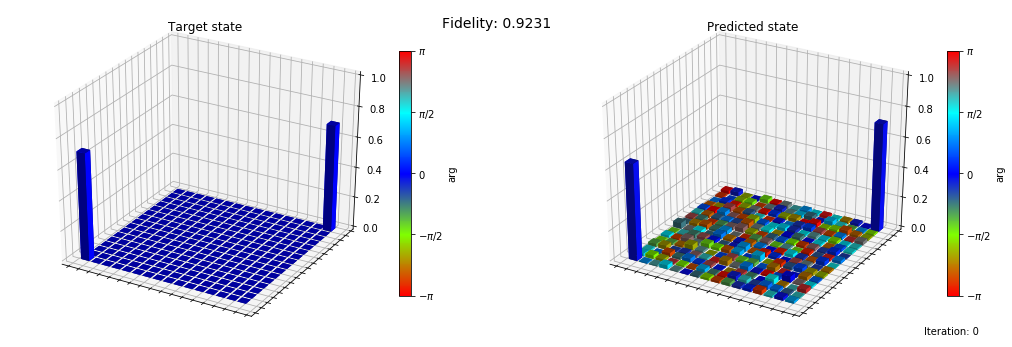

In [14]:
plot_state_comparison(out_data[0:1], model1.predict(in_data[0:1]), iteration=0)

In [15]:
for i, pred_state in enumerate(callback.predictions):
    print("Saving frame {}/{}...".format(i, len(callback.predictions)))
    plot_state_comparison(callback.predict_state, pred_state, iteration=i, savefig=True)

Saving frame 0/300...
Saving frame 1/300...
Saving frame 2/300...
Saving frame 3/300...
Saving frame 4/300...
Saving frame 5/300...
Saving frame 6/300...
Saving frame 7/300...
Saving frame 8/300...
Saving frame 9/300...
Saving frame 10/300...
Saving frame 11/300...
Saving frame 12/300...
Saving frame 13/300...
Saving frame 14/300...
Saving frame 15/300...
Saving frame 16/300...
Saving frame 17/300...
Saving frame 18/300...
Saving frame 19/300...
Saving frame 20/300...
Saving frame 21/300...
Saving frame 22/300...
Saving frame 23/300...
Saving frame 24/300...
Saving frame 25/300...
Saving frame 26/300...
Saving frame 27/300...
Saving frame 28/300...
Saving frame 29/300...
Saving frame 30/300...
Saving frame 31/300...
Saving frame 32/300...
Saving frame 33/300...
Saving frame 34/300...
Saving frame 35/300...
Saving frame 36/300...
Saving frame 37/300...
Saving frame 38/300...
Saving frame 39/300...
Saving frame 40/300...
Saving frame 41/300...
Saving frame 42/300...
Saving frame 43/300..